## 数据集为：‘abalone_benchmarks’，使用PyOD库中各类算法进行异常检测，并比较各类算法的精度。

In [16]:
import pandas as pd
import os
import numpy as np
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.model_selection import train_test_split
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

### 进行数据预处理，将'nominal'和 'anomaly': 分别映射为‘0’和‘1’，并提取V1-V7为特征，'ground.truth'为lable

In [17]:
label_mapping = {
           'nominal': 0,
           'anomaly': 1}
col_n = ['V1','V2','V3', 'V4','V5','V6', 'V7', 'ground.truth']

### 采用PYOD库中7种算法，分别为Angle-Based Outlier Detection (ABOD)，k-Nearest Neighbors Detector，Average KNN，Isolation Forest，Histogram-based Outlier Detection，Feature Bagging，Clustering Based Local Outlier Factor

In [18]:
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(check_estimator=False),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),check_estimator=False),
        'Histogram-base Outlier Detection (HBOS)': HBOS(),
        'Isolation Forest': IForest(),
        'K Nearest Neighbors (KNN)': KNN(),
        'Average KNN': KNN(method='mean')
}

### 数据集包括近1800个CSV文件，首先读取目录下所有数据文件

In [19]:
Roc_train=[]
Roc_test=[]
Prn_train=[]
Prn_test=[]

path='C:/Users/ThinkPad/Desktop/dm-data/abalone/benchmarks'
files= os.listdir(path)

### 分别用7种算法对所有进1800个数据进行预测，每一份数据文件按照80%为训练集，20%为测试集进行划分，针对训练集和测试集分别计算Roc和precision @ rank n两项指标,并抽样显示预测精度结果。

In [20]:
a=0
for file in files: 
    
    
    df = pd.read_csv(path+'/'+file)
    df['ground.truth'] = df['ground.truth'].map(label_mapping)
    
    data = pd.DataFrame(df,columns = col_n)
        
    x = data.iloc[:, :-1]
    y = data.iloc[:, -1:]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    

    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    roc_train=[]
    roc_test=[]
    prn_train=[]
    prn_test=[]
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(x_train)
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores
        
        # get the prediction on the test data
        y_test_pred = clf.predict(x_test)  # outlier labels (0 or 1)
        y_test_scores = clf.decision_function(x_test)  # outlier scores
        
        roc_train.append(roc_auc_score(y_train, y_train_scores))
        roc_test.append(roc_auc_score(y_test, y_test_scores))
        
        prn_train.append(precision_n_scores(y_train, y_train_scores))
        prn_test.append(precision_n_scores(y_test, y_test_scores))
    
    a=a+1
    if a%100==0:
        print('数据文件：',file, '，其测试集ROC为:',np.round(roc_test, decimals=3),)    
    Roc_train.append(roc_train)
    Roc_test.append(roc_test)
    Prn_train.append(prn_train)
    Prn_test.append(prn_test)

数据文件： abalone_benchmark_0105.csv ，其测试集ROC为: [0.961 0.752 0.599 0.73  0.591 0.983 0.983]
数据文件： abalone_benchmark_0206.csv ，其测试集ROC为: [0.696 0.565 0.571 0.477 0.457 0.705 0.707]
数据文件： abalone_benchmark_0306.csv ，其测试集ROC为: [0.531 0.202 0.361 0.646 0.602 0.65  0.653]
数据文件： abalone_benchmark_0483.csv ，其测试集ROC为: [0.607 0.236 0.637 0.025 0.125 0.483 0.533]
数据文件： abalone_benchmark_0602.csv ，其测试集ROC为: [0.944 0.847 0.812 0.918 0.906 0.955 0.947]
数据文件： abalone_benchmark_0716.csv ，其测试集ROC为: [1. 1. 1. 1. 1. 1. 1.]
数据文件： abalone_benchmark_0821.csv ，其测试集ROC为: [0.971 0.863 0.942 0.591 0.807 0.937 0.942]
数据文件： abalone_benchmark_0928.csv ，其测试集ROC为: [0.833 0.661 0.637 0.834 0.769 0.846 0.848]
数据文件： abalone_benchmark_1028.csv ，其测试集ROC为: [0.822 0.778 0.809 0.715 0.737 0.825 0.829]
数据文件： abalone_benchmark_1128.csv ，其测试集ROC为: [0.928 0.902 0.828 0.928 0.913 0.94  0.936]
数据文件： abalone_benchmark_1236.csv ，其测试集ROC为: [0.726 0.646 0.616 0.684 0.641 0.731 0.72 ]
数据文件： abalone_benchmark_1336.csv ，其测试集ROC为: [0.838 0.

### 计算7种算法两项指标的的平均值

In [21]:
Roc_train=np.round(np.mean(Roc_train,axis=0), decimals=3)
Roc_test=np.round(np.mean(Roc_test,axis=0), decimals=3)
Prn_train=np.round(np.mean(Prn_train,axis=0), decimals=3)
Prn_test=np.round(np.mean(Prn_test,axis=0), decimals=3)

### 从结果可以看出，训练集两项指标略优于测试集，Angle-Based Outlier Detection (ABOD)，k-Nearest Neighbors Detector，Average KNN优于其他算法，其中KNN算法最优

In [22]:
print('训练集ROC:',Roc_train)
print('测试集ROC:',Roc_test)
print('训练集PRN:',Prn_train)
print('测试集PRN:',Prn_test)

训练集ROC: [0.724 0.688 0.647 0.716 0.678 0.733 0.731]
测试集ROC: [0.71  0.679 0.635 0.719 0.674 0.72  0.717]
训练集PRN: [0.302 0.281 0.23  0.296 0.267 0.324 0.324]
测试集PRN: [0.316 0.297 0.242 0.309 0.278 0.343 0.34 ]


### 通过柱状图进行直观比较各类算法ROC和Prn的具体表现

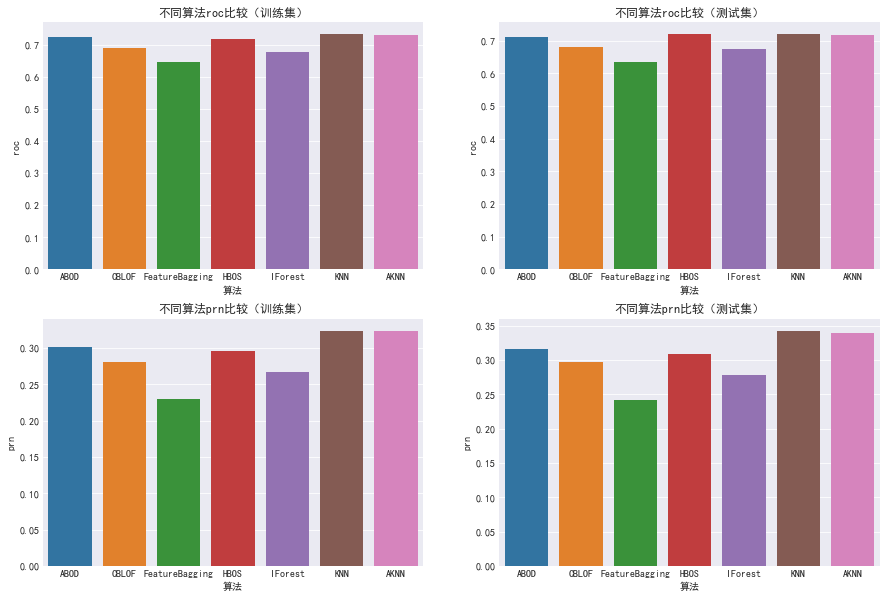

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

x=['ABOD','CBLOF','FeatureBagging','HBOS','IForest','KNN','AKNN']

fig,axes=plt.subplots(2,2,figsize=(15, 10))
sns.barplot(x, Roc_train,ax=axes[0][0])
sns.barplot(x, Roc_test,ax=axes[0][1])
sns.barplot(x, Prn_train,ax=axes[1][0])
sns.barplot(x, Prn_test,ax=axes[1][1])
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('darkgrid', {'font.sans-serif':['SimHei', 'Arial']})
axes[0][0].set_xlabel('算法', fontsize=10)
axes[0][0].set_ylabel('roc', fontsize=10)
axes[0][0].set_title('不同算法roc比较（训练集）')
axes[0][1].set_xlabel('算法', fontsize=10)
axes[0][1].set_ylabel('roc', fontsize=10)
axes[0][1].set_title('不同算法roc比较（测试集）')
axes[1][0].set_xlabel('算法', fontsize=10)
axes[1][0].set_ylabel('prn', fontsize=10)
axes[1][0].set_title('不同算法prn比较（训练集）')
axes[1][1].set_xlabel('算法', fontsize=10)
axes[1][1].set_ylabel('prn', fontsize=10)
axes[1][1].set_title('不同算法prn比较（测试集）')

plt.show()